# [Keras_ImageGenerator](https://keras.io/preprocessing/image/)

In [ ]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPool2D, Activation, Dense, BatchNormalization, Flatten
from keras.optimizers import adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.backend import clear_session
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from math import ceil

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
x_train, x_test = x_train/255., x_test/255.
y_train, y_test = to_categorical(y_train, num_classes=10), to_categorical(y_test, num_classes=10)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# Data_Augmentation

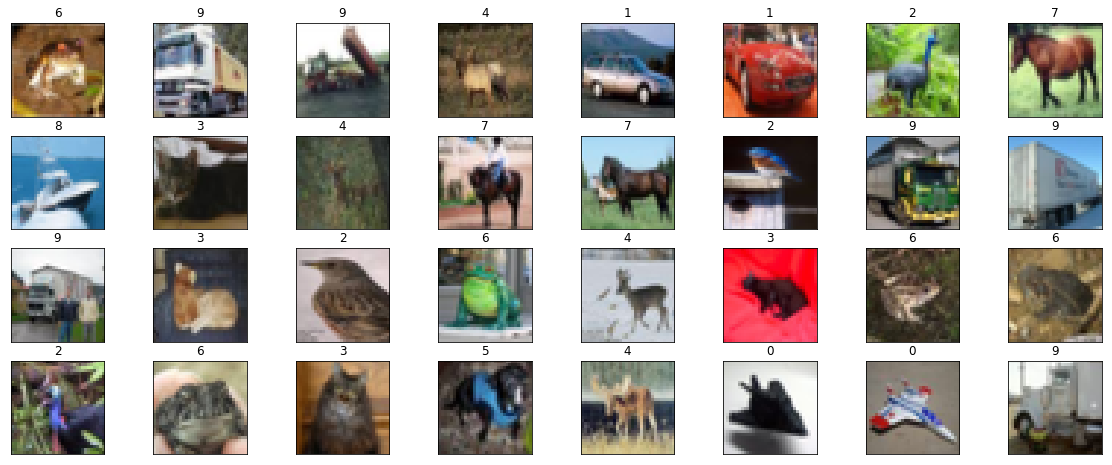

In [66]:
preview_images = x_train[:32, :, :, :]
preview_labels = y_train[:32]
def show_image(preview_images, preview_labels, n_col=8):
    fig = plt.figure(figsize=(20, 10))
    for idx in range(len(preview_images)):
        ax = fig.add_subplot(len(preview_images)//n_col+1, n_col, idx+1, xticks=[], yticks=[])
        ax.imshow(preview_images[idx, :, :, :])
        ax.set_title(str(preview_labels[idx].argmax(axis=0)))
show_image(preview_images, preview_labels, 8)
        

(32, 32, 32, 3)


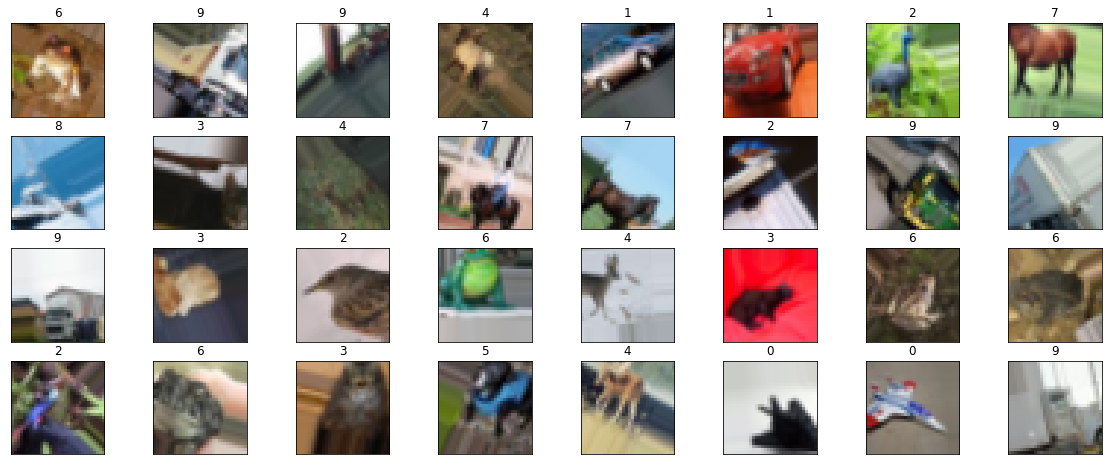

In [67]:
data_generator = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   horizontal_flip=True)

#data_generator.fit(x_train) 
augmentation_images, labels = next(data_generator.flow(x_train, y_train, batch_size=32, shuffle=False))
show_image(augmentation_images, labels)

In [75]:
clear_session()
input_layer = Input(x_train.shape[1:])
x = Conv2D(filters=512, kernel_size=(3, 3), padding='valid')(input_layer)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='valid')(x)
x = Activation('relu')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='valid')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid')(x)
x = Activation('relu')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPool2D((2, 2))(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)
model_cnn = Model(inputs=[input_layer], outputs=[output_layer])
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 512)       14336     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       1179904   
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       295040    
__________

In [76]:
data_generator = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   horizontal_flip=True)
normal_generator = ImageDataGenerator()

In [77]:
EPOCHS = 100
LEARNINGRATE = 1e-3
BATCH_SIZE = 50
OPTIMIZER = adam(lr=LEARNINGRATE)

#callbacks
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint(monitor='val_loss', filepath='cifar10_cnn.h5', 
                             save_best_only=True, verbose=1)


model_cnn.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
history = model_cnn.fit_generator(data_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        epochs=EPOCHS,
                        steps_per_epoch= ceil(len(x_train) / BATCH_SIZE),
                        validation_data = normal_generator.flow(x_test, y_test, batch_size=BATCH_SIZE),
                        validation_steps= ceil(len(x_test / BATCH_SIZE)),
                        callbacks = [lr_reducer, early_stop, checkpoint]
                       )


Epoch 1/100
1000/1000 [==============================] - 131s 131ms/step - loss: 1.9148 - acc: 0.2999 - val_loss: 1.9008 - val_acc: 0.3526

Epoch 00001: val_loss improved from inf to 1.90080, saving model to cifar10_cnn.h5
Epoch 2/100
1000/1000 [==============================] - 128s 128ms/step - loss: 1.6415 - acc: 0.4037 - val_loss: 1.7362 - val_acc: 0.3888

Epoch 00002: val_loss improved from 1.90080 to 1.73619, saving model to cifar10_cnn.h5
Epoch 3/100
1000/1000 [==============================] - 129s 129ms/step - loss: 1.5142 - acc: 0.4530 - val_loss: 1.7833 - val_acc: 0.3998

Epoch 00003: val_loss did not improve from 1.73619
Epoch 4/100
1000/1000 [==============================] - 128s 128ms/step - loss: 1.4243 - acc: 0.4892 - val_loss: 1.4835 - val_acc: 0.5019

Epoch 00004: val_loss improved from 1.73619 to 1.48349, saving model to cifar10_cnn.h5
Epoch 5/100
1000/1000 [==============================] - 128s 128ms/step - loss: 1.3561 - acc: 0.5145 - val_loss: 1.5713 - val_acc: 


Epoch 00040: val_loss improved from 0.76908 to 0.75755, saving model to cifar10_cnn.h5
Epoch 41/100
1000/1000 [==============================] - 129s 129ms/step - loss: 0.8093 - acc: 0.7179 - val_loss: 0.7428 - val_acc: 0.7497

Epoch 00041: val_loss improved from 0.75755 to 0.74282, saving model to cifar10_cnn.h5
Epoch 42/100
1000/1000 [==============================] - 129s 129ms/step - loss: 0.8002 - acc: 0.7210 - val_loss: 0.7757 - val_acc: 0.7404

Epoch 00042: val_loss did not improve from 0.74282
Epoch 43/100
1000/1000 [==============================] - 129s 129ms/step - loss: 0.7943 - acc: 0.7224 - val_loss: 0.7489 - val_acc: 0.7471

Epoch 00043: val_loss did not improve from 0.74282
Epoch 44/100
1000/1000 [==============================] - 129s 129ms/step - loss: 0.7969 - acc: 0.7228 - val_loss: 0.7444 - val_acc: 0.7462

Epoch 00044: val_loss did not improve from 0.74282
Epoch 45/100
1000/1000 [==============================] - 129s 129ms/step - loss: 0.7980 - acc: 0.7234 - val

In [80]:
valid_loss, valid_acc = model_cnn.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 235us/step


Text(0.5, 1.0, 'Accuracy')

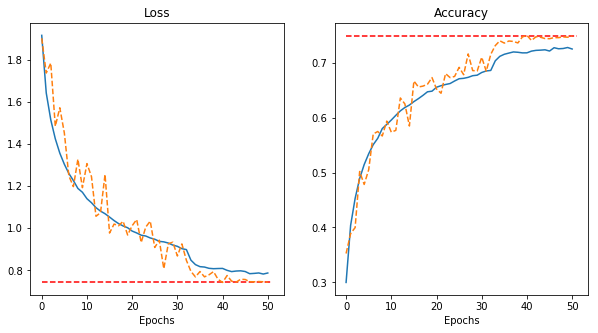

In [86]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(range(len(history.history['loss'])), history.history['loss'], label='tarin')
ax1.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='valid', linestyle='--')
ax2.plot(range(len(history.history['acc'])), history.history['acc'], label='tarin')
ax2.plot(range(len(history.history['val_acc'])), history.history['val_acc'], label='valid', linestyle='--')
ax1.hlines(valid_loss, 0, len(history.history['loss']), color='r', linestyle='--')
ax2.hlines(valid_acc, 0, len(history.history['loss']), color='r', linestyle='--')
ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')
ax1.set_title('Loss')
ax2.set_title('Accuracy');